https://www.dataquest.io/blog/data-science-portfolio-project/?utm_source=intercom&utm_medium=email&utm_campaign=signup_10day_porfolio

The main components of storytelling with data are:

* Understanding and setting the context
* Exploring multiple angles - main data + supplemental data
* Using compelling visualizations
* Using varied data sources
* Having a consistent narrative

### Background Information
Before diving into analyzing the data, it’s useful to research some background information. In this case, we know a few facts that will be useful:

* New York City is divided into 5 boroughs, which are essentially distinct regions.
* Schools in New York City are divided into several school district, each of which can contains dozens of schools.
* Not all the schools in all of the datasets are high schools, so we’ll need to do some data cleaning.
* Each school in New York City has a unique code called a DBN, or District Borough Number.
* By aggregating data by district, we can use the district mapping data to plot district-by-district differences.

### Understanding the Data
* Loop through each data file we downloaded.
* Read the file into a Pandas DataFrame.
* Put each DataFrame into a Python dictionary.

In [1]:
import pandas
import numpy as np

files = ["ap_results.csv", "class_size.csv", "demographics.csv", "graduation.csv", "hs_directory.csv", "math_test_results.csv", "sat_results.csv"]

data = {}
for f in files:
    d = pandas.read_csv("./data/NYC-Schools/{0}".format(f),encoding="ISO-8859-1")
    data[f.replace(".csv", "")] = d

In [2]:
#data["hs_directory"].head()
for k,v in data.items():
    print("\n" + k + "\n")
    print(v.head())


ap_results

      DBN                                        SCHOOL NAME  \
0  01M292      HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M458                          FORSYTH SATELLITE ACADEMY   
2  01M650                               CASCADES HIGH SCHOOL   
3  01M696                     BARD HIGH SCHOOL EARLY COLLEGE   
4  02M047  47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...   

   Num of AP Test Takers  Num of AP Total Exams Taken  Num of AP Exams Passed  
0                    NaN                          NaN                     NaN  
1                    NaN                          NaN                     NaN  
2                    NaN                          NaN                     NaN  
3                    NaN                          NaN                     NaN  
4                    NaN                          NaN                     NaN  

class_size

   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S.

Initial thoughts:

* Most of the datasets contain a DBN column - use to join the data sets. Will need to add this column in class_size dataset.
* Some fields look interesting for mapping, particularly Location 1, which contains coordinates inside a larger string.
* Some of the datasets appear to contain multiple rows for each school (repeated DBN values), which means we’ll have to do some preprocessing.

### DBM
All of the datasets have a DBN (unique code for each school) except for the class_size dataset. We will need to see if we can create this column there.

In [3]:
# what our DBM should look like
data["demographics"]["DBN"].head()

0    01M015
1    01M015
2    01M015
3    01M015
4    01M015
Name: DBN, dtype: object

In [4]:
data["class_size"].head()

CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1       M        M015  P.S. 015 Roberto Clemente     01       GEN ED   
3    1       M        M015  P.S. 015 Roberto Clemente     01          CTT   
4    1       M        M015  P.S. 015 Roberto Clemente     02       GEN ED   

  CORE SUBJECT (MS CORE and 9-12 ONLY) CORE COURSE (MS CORE and 9-12 ONLY)  \
0                                    -                                   -   
1                                    -                                   -   
2                                    -                                   -   
3                                    -                                   -   
4                                    -                                   -   

  SERVICE CATEGORY(K-9* ONLY)  NUMBER OF STUDENTS / SEATS FILLED  \
0                           -                               19.0   
1                           -                               21.0   
2                           -                               17.0   
3                           -                               17.0   
4                           -                               15.0   

   NUMBER OF SECTIONS  AVERAGE CLASS SIZE  SIZE OF SMALLEST CLASS  \
0                 1.0                19.0                    19.0   
1                 1.0                21.0                    21.0   
2                 1.0                17.0                    17.0   
3                 1.0                17.0                    17.0   
4                 1.0                15.0                    15.0   

   SIZE OF LARGEST CLASS DATA SOURCE  SCHOOLWIDE PUPIL-TEACHER RATIO  
0                   19.0         ATS                             NaN  
1                   21.0         ATS                             NaN  
2                   17.0         ATS                             NaN  
3                   17.0         ATS                             NaN  
4                   15.0         ATS                             NaN

In [5]:
# constructing the DBM for class_size
data["class_size"]["DBN"] = data["class_size"].apply(lambda x: "{0:02d}{1}".format(x["CSD"], x["SCHOOL CODE"]), axis=1)

In [6]:
data["class_size"]["DBN"].head()

0    01M015
1    01M015
2    01M015
3    01M015
4    01M015
Name: DBN, dtype: object

### Survey Data
* Read in the surveys for all schools using the windows-1252 file encoding.
* Read in the surveys for district 75 schools using the windows-1252 file encoding.
* Add a flag that indicates which school district each dataset is for.
* Combine the datasets into one using the concat method on DataFrames.

In [7]:
survey1 = pandas.read_csv("./data/NYC-Schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
survey2 = pandas.read_csv("./data/NYC-Schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey1["d75"] = False
survey2["d75"] = True
survey = pandas.concat([survey1, survey2], axis=0)

In [8]:
survey.head()

N_p    N_s   N_t  aca_p_11  aca_s_11  aca_t_11  aca_tot_11    bn  \
0   90.0    NaN  22.0       7.8       NaN       7.9         7.9  M015   
1  161.0    NaN  34.0       7.8       NaN       9.1         8.4  M019   
2  367.0    NaN  42.0       8.6       NaN       7.5         8.0  M020   
3  151.0  145.0  29.0       8.5       7.4       7.8         7.9  M034   
4   90.0    NaN  23.0       7.9       NaN       8.1         8.0  M063   

   com_p_11  com_s_11   ...    t_q8c_1  t_q8c_2 t_q8c_3 t_q8c_4  t_q9  t_q9_1  \
0       7.6       NaN   ...       29.0     67.0     5.0     0.0   NaN     5.0   
1       7.6       NaN   ...       74.0     21.0     6.0     0.0   NaN     3.0   
2       8.3       NaN   ...       33.0     35.0    20.0    13.0   NaN     3.0   
3       8.2       5.9   ...       21.0     45.0    28.0     7.0   NaN     0.0   
4       7.9       NaN   ...       59.0     36.0     5.0     0.0   NaN    10.0   

   t_q9_2  t_q9_3  t_q9_4  t_q9_5  
0    14.0    52.0    24.0     5.0  
1     6.0     3.0    78.0     9.0  
2     5.0    16.0    70.0     5.0  
3    18.0    32.0    39.0    11.0  
4     5.0    10.0    60.0    15.0  

[5 rows x 2773 columns]

In [9]:
# only keep useful columns
survey["DBN"] = survey["dbn"]
survey_fields = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_10", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11",]
survey = survey.loc[:,survey_fields]
data["survey"] = survey
survey.shape

(1702, 23)

### Condensing Rows

In [10]:
data["class_size"].head()

CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1       M        M015  P.S. 015 Roberto Clemente     01       GEN ED   
3    1       M        M015  P.S. 015 Roberto Clemente     01          CTT   
4    1       M        M015  P.S. 015 Roberto Clemente     02       GEN ED   

  CORE SUBJECT (MS CORE and 9-12 ONLY) CORE COURSE (MS CORE and 9-12 ONLY)  \
0                                    -                                   -   
1                                    -                                   -   
2                                    -                                   -   
3                                    -                                   -   
4                                    -                                   -   

  SERVICE CATEGORY(K-9* ONLY)  NUMBER OF STUDENTS / SEATS FILLED  \
0                           -                               19.0   
1                           -                               21.0   
2                           -                               17.0   
3                           -                               17.0   
4                           -                               15.0   

   NUMBER OF SECTIONS  AVERAGE CLASS SIZE  SIZE OF SMALLEST CLASS  \
0                 1.0                19.0                    19.0   
1                 1.0                21.0                    21.0   
2                 1.0                17.0                    17.0   
3                 1.0                17.0                    17.0   
4                 1.0                15.0                    15.0   

   SIZE OF LARGEST CLASS DATA SOURCE  SCHOOLWIDE PUPIL-TEACHER RATIO     DBN  
0                   19.0         ATS                             NaN  01M015  
1                   21.0         ATS                             NaN  01M015  
2                   17.0         ATS                             NaN  01M015  
3                   17.0         ATS                             NaN  01M015  
4                   15.0         ATS                             NaN  01M015

The class_size dataset has multiple rows per school - for different grades and program types. We'll need to condense these in order to join them with the other datasets. To filter out the duplicates, we can:
* Only select values from class_size where the GRADE field is 09-12.
* Only select values from class_size where the PROGRAM TYPE field is GEN ED.
* Group the class_size dataset by DBN, and take the average of each column. Essentially, we’ll find the average class_size values for each school.
* Reset the index, so DBN is added back in as a column.

In [11]:
class_size = data["class_size"]
class_size = class_size[(class_size["GRADE "] == "09-12") & \
                        (class_size["PROGRAM TYPE"] == "GEN ED")]
class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

In [12]:
data["class_size"].head()

DBN  CSD  NUMBER OF STUDENTS / SEATS FILLED  NUMBER OF SECTIONS  \
0  01M292    1                            88.0000            4.000000   
1  01M332    1                            46.0000            2.000000   
2  01M378    1                            33.0000            1.000000   
3  01M448    1                           105.6875            4.750000   
4  01M450    1                            57.6000            2.733333   

   AVERAGE CLASS SIZE  SIZE OF SMALLEST CLASS  SIZE OF LARGEST CLASS  \
0           22.564286                   18.50              26.571429   
1           22.000000                   21.00              23.500000   
2           33.000000                   33.00              33.000000   
3           22.231250                   18.25              27.062500   
4           21.200000                   19.40              22.866667   

   SCHOOLWIDE PUPIL-TEACHER RATIO  
0                             NaN  
1                             NaN  
2                             NaN  
3                             NaN  
4                             NaN

The demographics dataset also contains duplicates for different school years. We will filter to show onlythe 2011-2012 year.

In [13]:
demographics = data["demographics"]
demographics = demographics[demographics["schoolyear"] == 20112012]
data["demographics"] = demographics

In [14]:
data["demographics"].head()

DBN                                              Name  schoolyear  \
6   01M015  P.S. 015 ROBERTO CLEMENTE                           20112012   
13  01M019  P.S. 019 ASHER LEVY                                 20112012   
20  01M020  PS 020 ANNA SILVER                                  20112012   
27  01M034  PS 034 FRANKLIN D ROOSEVELT                         20112012   
35  01M063  PS 063 WILLIAM MCKINLEY                             20112012   

   fl_percent  frl_percent  total_enrollment prek    k grade1 grade2  \
6         NaN         89.4               189   13   31     35     28   
13        NaN         61.5               328   32   46     52     54   
20        NaN         92.5               626   52  102    121     87   
27        NaN         99.7               401   14   34     38     36   
35        NaN         78.9               176   18   20     30     21   

      ...     black_num black_per hispanic_num hispanic_per white_num  \
6     ...            63      33.3          109         57.7         4   
13    ...            81      24.7          158         48.2        28   
20    ...            55       8.8          357         57.0        16   
27    ...            90      22.4          275         68.6         8   
35    ...            41      23.3          110         62.5        15   

   white_per male_num male_per female_num female_per  
6        2.1     97.0     51.3       92.0       48.7  
13       8.5    147.0     44.8      181.0       55.2  
20       2.6    330.0     52.7      296.0       47.3  
27       2.0    204.0     50.9      197.0       49.1  
35       8.5     97.0     55.1       79.0       44.9  

[5 rows x 38 columns]

The math_test_results dataset contains multiple rows per school for different years and grades. We will filter to show 2011 scores for grade 8 only.

In [15]:
data["math_test_results"] = data["math_test_results"][data["math_test_results"]["Year"] == 2011]
data["math_test_results"] = data["math_test_results"][data["math_test_results"]["Grade"] == '8']

In [16]:
data["math_test_results"].head()

DBN Grade  Year      Category  Number Tested  Mean Scale Score  \
24   75Q177     8  2011  All Students              6             662.0   
53   75M035     8  2011  All Students              7             556.0   
107  02M347     8  2011  All Students              9             652.0   
182  75Q075     8  2011  All Students             11             627.0   
206  75K053     8  2011  All Students             12             609.0   

     Level 1 # Level 1 %  Level 2 # Level 2 %  Level 3 # Level 3 %  Level 4 #  \
24           1    16.70%          2    33.30%          3       50%          0   
53           5    71.40%          2    28.60%          0        0%          0   
107          3    33.30%          4    44.40%          2    22.20%          0   
182          6    54.50%          4    36.40%          1     9.10%          0   
206          7    58.30%          5    41.70%          0        0%          0   

    Level 4 %  Level 3+4 # Level 3+4 %  
24         0%            3         50%  
53         0%            0          0%  
107        0%            2      22.20%  
182        0%            1       9.10%  
206        0%            0          0%

The graduation dataset contains multiple rows per school for different cohorts and demographics. We will filter for 2006 and Total Cohort only.

In [17]:
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

In [18]:
data["graduation"].head()

Demographic     DBN                            School Name Cohort  \
3   Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL   2006   
10  Total Cohort  01M448    UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   2006   
17  Total Cohort  01M450             EAST SIDE COMMUNITY SCHOOL   2006   
24  Total Cohort  01M509                MARTA VALLE HIGH SCHOOL   2006   
31  Total Cohort  01M515  LOWER EAST SIDE PREPARATORY HIGH SCHO   2006   

    Total Cohort Total Grads - n Total Grads - % of cohort Total Regents - n  \
3             78              43                     55.1%                36   
10           124              53                     42.7%                42   
17            90              70                     77.8%                67   
24            84              47                       56%                40   
31           193             105                     54.4%                91   

   Total Regents - % of cohort Total Regents - % of grads  \
3                        46.2%                      83.7%   
10                       33.9%                      79.2%   
17         74.400000000000006%                      95.7%   
24                       47.6%                      85.1%   
31                       47.2%                      86.7%   

              ...            Regents w/o Advanced - n  \
3             ...                                  36   
10            ...                                  34   
17            ...                                  67   
24            ...                                  23   
31            ...                                  22   

   Regents w/o Advanced - % of cohort Regents w/o Advanced - % of grads  \
3                               46.2%                             83.7%   
10                              27.4%                             64.2%   
17                74.400000000000006%                             95.7%   
24                              27.4%                             48.9%   
31                              11.4%                               21%   

   Local - n Local - % of cohort Local - % of grads Still Enrolled - n  \
3          7                  9%              16.3%                 16   
10        11                8.9%              20.8%                 46   
17         3                3.3%               4.3%                 15   
24         7  8.300000000000001%              14.9%                 25   
31        14                7.3%              13.3%                 53   

   Still Enrolled - % of cohort Dropped Out - n Dropped Out - % of cohort  
3                         20.5%              11                     14.1%  
10                        37.1%              20       16.100000000000001%  
17                        16.7%               5                      5.6%  
24                        29.8%               5                        6%  
31                        27.5%              35       18.100000000000001%  

[5 rows x 23 columns]

### Computing Variables
We can compute a total SAT score from the individual columns SAT Math Avg. Score, SAT Critical Reading Avg. Score, and SAT Writing Avg. Score. In the below code, we:
* Convert each of the SAT score columns from a string to a number.
* Add together all of the columns to get the sat_score column, which is the total SAT score.

In [19]:
data["sat_results"].head()

DBN                                   SCHOOL NAME  \
0  08X408                        HERBERT H. LEHMAN YABC   
1  28Q338  QUEENS SATELLITE HIGH SCHOOL FOR OPPORTUNITY   
2  01M458                     FORSYTH SATELLITE ACADEMY   
3  06M457                        GEORGE WASHINGTON YABC   
4  17K489            W.E.B. DUBOIS ACADEMIC HIGH SCHOOL   

   Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                       6                              402   
1                       6                              403   
2                       7                              414   
3                       7                              394   
4                       7                              394   

   SAT Math Avg. Score  SAT Writing Avg. Score  
0                  373                     413  
1                  408                     367  
2                  401                     359  
3                  357                     346  
4                  364                     334

In [20]:
# we want to convert the scores from string objects to numbers
data["sat_results"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 6 columns):
DBN                                421 non-null object
SCHOOL NAME                        421 non-null object
Num of SAT Test Takers             421 non-null int64
SAT Critical Reading Avg. Score    421 non-null int64
SAT Math Avg. Score                421 non-null int64
SAT Writing Avg. Score             421 non-null int64
dtypes: int64(4), object(2)
memory usage: 19.8+ KB


In [21]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c])

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

In [22]:
data["sat_results"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 7 columns):
DBN                                421 non-null object
SCHOOL NAME                        421 non-null object
Num of SAT Test Takers             421 non-null int64
SAT Critical Reading Avg. Score    421 non-null int64
SAT Math Avg. Score                421 non-null int64
SAT Writing Avg. Score             421 non-null int64
sat_score                          421 non-null int64
dtypes: int64(5), object(2)
memory usage: 23.1+ KB


We can parse out the coordinate locations of each school to plot the schools on a map.
* Parse latitude and longitude columns from the Location 1 column.
* Convert lat and lon to be numeric.

In [23]:
data["hs_directory"]['lat'] = data["hs_directory"]['Location 1'].apply(lambda x: x.split("\n")[-1].replace("(", "").replace(")", "").split(", ")[0])
data["hs_directory"]['lon'] = data["hs_directory"]['Location 1'].apply(lambda x: x.split("\n")[-1].replace("(", "").replace(")", "").split(", ")[1])

for c in ['lat', 'lon']:
    data["hs_directory"][c] = pandas.to_numeric(data["hs_directory"][c])

In [24]:
data["hs_directory"].head()

DBN Boro    BN Building Code School_Phone_Number    Fax_Number  \
0  01M292    M  M292          M056        212-406-9411  212-406-9417   
1  01M448    M  M448          M446        212-962-4341  212-267-5611   
2  01M450    M  M450          M060        212-460-8467  212-260-9657   
3  01M509    M  M509          M025        212-473-8152  212-475-7588   
4  01M539    M  M539          M022        212-677-5190  212-260-8124   

                                        Printed_Name  \
0      Henry Street School for International Studies   
1                University Neighborhood High School   
2                         East Side Community School   
3                            Marta Valle High School   
4  New Explorations into Science, Technology and ...   

                                Alphabetic_Name_Long grade span 2014-2015 min  \
0      Henry Street School for International Studies                        6   
1                University Neighborhood High School                        9   
2                         East Side Community School                        6   
3                            Marta Valle High School                        9   
4  New Explorations into Science, Technology and ...                       0K   

   grade span 2014-2015 max    ...     school_district   latitude  longitude  \
0                        12    ...                   1  40.713481 -73.985321   
1                        12    ...                   1  40.712235 -73.983823   
2                        12    ...                   1  40.729846 -73.983151   
3                        12    ...                   1  40.720555 -73.985684   
4                        12    ...                   1  40.719493 -73.979151   

                               loc           @context   @type  \
0  [-73.98532120000002,40.7134809]  http://schema.org  School   
1           [-73.983823,40.712235]  http://schema.org  School   
2         [-73.9831511,40.7298459]  http://schema.org  School   
3         [-73.9856836,40.7205546]  http://schema.org  School   
4         [-73.9791505,40.7194927]  http://schema.org  School   

                                                 @id  \
0  http://nyc.pediacities.com/Resource/School/hen...   
1  http://nyc.pediacities.com/Resource/School/uni...   
2  http://nyc.pediacities.com/Resource/School/eas...   
3  http://nyc.pediacities.com/Resource/School/mar...   
4  http://nyc.pediacities.com/Resource/School/new...   

                                          Location 1        lat        lon  
0  220 Henry Street\nNew York, NY 10002\n(40.7134...  40.713481 -73.985321  
1  200 Monroe Street\nNew York, NY 10002\n(40.712...  40.712235 -73.983823  
2  420 East 12 Street\nNew York, NY 10009\n(40.72...  40.729846 -73.983151  
3  145 Stanton Street\nNew York, NY 10002\n(40.72...  40.720555 -73.985684  
4  111 Columbia Street\nNew York, NY 10002\n(40.7...  40.719493 -73.979151  

[5 rows x 73 columns]

### Combining Datasets
http://pandas.pydata.org/pandas-docs/stable/merging.html
* Loop through each of the items in the data dictionary.
* Print the number of non-unique DBNs in the item.
* Decide on a join strategy – inner or outer.
* Join the item to the DataFrame full using the column DBN.

In [25]:
flat_data_names = [k for k,v in data.items()]
flat_data = [data[k] for k in flat_data_names]
full = flat_data[0]
for i, f in enumerate(flat_data[1:]):
    name = flat_data_names[i+1]
    print(name)
    print(len(f["DBN"]) - len(f["DBN"].unique()))
    join_type = "inner"
    if name in ["sat_results", "ap_2010", "graduation"]:
        join_type = "outer"
    if name not in ["math_test_results"]:
        full = full.merge(f, on="DBN", how=join_type)

full.shape

class_size
0
demographics
0
graduation
0
hs_directory
0
math_test_results
0
sat_results
0
survey
0


(446, 171)

### Additional Data Cleaning

Notice that some rows in the ap_2010 file contain 's' which we will need to change.

In [26]:
data["ap_results"].head()

DBN                                        SCHOOL NAME  \
0  01M292      HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M458                          FORSYTH SATELLITE ACADEMY   
2  01M650                               CASCADES HIGH SCHOOL   
3  01M696                     BARD HIGH SCHOOL EARLY COLLEGE   
4  02M047  47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...   

   Num of AP Test Takers  Num of AP Total Exams Taken  Num of AP Exams Passed  
0                    NaN                          NaN                     NaN  
1                    NaN                          NaN                     NaN  
2                    NaN                          NaN                     NaN  
3                    NaN                          NaN                     NaN  
4                    NaN                          NaN                     NaN

In [27]:
# transform AP columns to numbers and fill in nulls
cols = ['Num of AP Test Takers', 'Num of AP Total Exams Taken', 'Num of AP Exams Passed']

for col in cols:
    full[col] = pandas.to_numeric(full[col])

full[cols] = full[cols].fillna(value=0)

Add in column for school district based first 2 digits on DBN.

In [28]:
full["school_dist"] = full["DBN"].apply(lambda x: x[:2])

Fill in any missing values in full with the mean of the column, so we can compute correlations.

In [29]:
full = full.fillna(full.mean())

### Computing Correlations

In [30]:
full.corr()['sat_score']

Num of AP Test Takers                0.571888
Num of AP Total Exams Taken          0.564819
Num of AP Exams Passed               0.560378
CSD                                  0.043092
NUMBER OF STUDENTS / SEATS FILLED    0.377269
NUMBER OF SECTIONS                   0.347392
AVERAGE CLASS SIZE                   0.363148
SIZE OF SMALLEST CLASS               0.232471
SIZE OF LARGEST CLASS                0.304539
SCHOOLWIDE PUPIL-TEACHER RATIO            NaN
schoolyear                                NaN
frl_percent                         -0.683411
total_enrollment                     0.351275
ell_num                             -0.137841
ell_percent                         -0.370955
sped_num                             0.033257
sped_percent                        -0.435653
asian_num                            0.452234
asian_per                            0.539994
black_num                            0.027482
black_per                           -0.272677
hispanic_num                      

This gives us quite a few insights that we’ll need to explore:

* Total enrollment correlates strongly with sat_score, which is surprising, because you’d think smaller schools, which focused more on the student, would have higher scores.
* The percentage of females at a school (female_per) correlates positively with SAT score, whereas the percentage of males (male_per) correlates negatively.
* None of the survey responses correlate highly with SAT scores.
* There is a significant racial inequality in SAT scores (white_per, asian_per, black_per, hispanic_per).
* ell_percent correlates strongly negatively with SAT scores.

In [31]:
full.head()

DBN                                      SCHOOL NAME_x  \
0  01M292      HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M696                     BARD HIGH SCHOOL EARLY COLLEGE   
2  02M047  47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...   
3  02M294                               ESSEX STREET ACADEMY   
4  02M296              HIGH SCHOOL OF HOSPITALITY MANAGEMENT   

   Num of AP Test Takers  Num of AP Total Exams Taken  Num of AP Exams Passed  \
0                    0.0                          0.0                     0.0   
1                    0.0                          0.0                     0.0   
2                    0.0                          0.0                     0.0   
3                    0.0                          0.0                     0.0   
4                    0.0                          0.0                     0.0   

   CSD  NUMBER OF STUDENTS / SEATS FILLED  NUMBER OF SECTIONS  \
0  1.0                          88.000000            4.000000   
1  1.0                         214.166667           10.250000   
2  2.0                          26.818182            1.636364   
3  2.0                          65.000000            4.357143   
4  2.0                         100.000000            4.428571   

   AVERAGE CLASS SIZE  SIZE OF SMALLEST CLASS     ...      aca_t_11  saf_s_11  \
0           22.564286               18.500000     ...           6.5       6.0   
1           20.975000               17.166667     ...           8.3       8.3   
2           16.072727               15.090909     ...           7.2       7.3   
3           14.900000               12.285714     ...           8.9       7.4   
4           22.964286               16.214286     ...           8.9       7.1   

  com_s_11  eng_s_11 aca_s_11  saf_tot_11  com_tot_11 eng_tot_11 aca_tot_11  \
0      5.6       6.1      6.7         6.7         6.2        6.6        7.0   
1      7.3       8.0      8.9         8.5         7.6        8.0        8.7   
2      6.3       7.0      7.5         8.1         6.7        7.5        7.6   
3      6.5       7.3      7.6         7.9         7.3        7.7        8.2   
4      6.5       7.0      7.4         7.9         7.3        7.6        8.0   

  school_dist  
0          01  
1          01  
2          02  
3          02  
4          02  

[5 rows x 172 columns]

### Mapping

In [32]:
import folium
from folium import plugins

schools_map = folium.Map(location=[full['lat'].mean(), full['lon'].mean()], zoom_start=10)
marker_cluster = folium.MarkerCluster().add_to(schools_map)
for name, row in full.iterrows():
    folium.Marker([row["lat"], row["lon"]], popup="{0}: {1}".format(row["DBN"], row["SCHOOL NAME_x"])).add_to(marker_cluster)
schools_map

A Heatmap might make it easier to see the schools.

In [33]:
schools_heatmap = folium.Map(location=[full['lat'].mean(), full['lon'].mean()], zoom_start=10)
schools_heatmap.add_child(plugins.HeatMap([[row["lat"], row["lon"]] for name, row in full.iterrows()]))
schools_heatmap

We can compute SAT score by school district, then plot this out on a map.
* Group 'full' by school district.
* Compute the average of each column for each school district. This will give us 1 row per school district (currently 32 districts).
* Convert the school_dist field to remove leading 0s, so we can match our geographic district data.

In [34]:
district_data = full.groupby("school_dist").agg(np.mean)
district_data.reset_index(inplace=True)
district_data["school_dist"] = district_data["school_dist"].apply(lambda x: str(int(x)))

In [35]:
district_data.head()

school_dist  Num of AP Test Takers  Num of AP Total Exams Taken  \
0           1              41.000000                    74.111111   
1           2              63.859375                    96.890625   
2           3              77.937500                   121.750000   
3           4              62.142857                    84.428571   
4           5              43.800000                    53.600000   

   Num of AP Exams Passed       CSD  NUMBER OF STUDENTS / SEATS FILLED  \
0               38.222222  5.350877                         134.234050   
1               66.187500  5.013158                         155.417629   
2               84.937500  5.763158                         160.057913   
3               46.428571  5.436090                         147.207915   
4               34.500000  7.715789                         136.100831   

   NUMBER OF SECTIONS  AVERAGE CLASS SIZE  SIZE OF SMALLEST CLASS  \
0            5.601239           23.382291               19.144654   
1            5.891430           24.977599               20.456295   
2            6.006060           23.986244               19.762489   
3            5.735576           23.970231               19.288985   
4            5.343562           24.441986               20.264423   

   SIZE OF LARGEST CLASS     ...      eng_t_10  aca_t_11  saf_s_11  com_s_11  \
0              27.274766     ...           NaN  7.966667  7.064806  6.260231   
1              28.624949     ...           NaN  7.610937  7.045051  6.350658   
2              27.521676     ...           NaN  6.975000  6.731250  6.193750   
3              27.571296     ...           NaN  7.471429  6.728571  6.014286   
4              28.038155     ...           NaN  7.080000  6.270000  5.920000   

   eng_s_11  aca_s_11  saf_tot_11  com_tot_11  eng_tot_11  aca_tot_11  
0  6.830744  7.467345    7.688889    6.955556    7.300000    7.833333  
1  6.798073  7.484470    7.582813    6.815625    7.140625    7.621875  
2  6.606250  7.318750    7.206250    6.556250    6.868750    7.356250  
3  6.557143  7.371429    7.471429    6.728571    6.971429    7.542857  
4  6.380000  7.210000    7.100000    6.510000    6.770000    7.340000  

[5 rows x 74 columns]

In [36]:
geo_path = './data/NYC-Schools/districts.geojson'

districts = folium.Map(location=[full['lat'].mean(), full['lon'].mean()], zoom_start=10)
districts.choropleth(geo_path=geo_path, data=district_data,
             columns=['school_dist', 'sat_score'],
             key_on='feature.properties.school_dist',
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.7,
             legend_name='SAT Score')
# add markers
# for name, row in district_data.iterrows():
#    folium.CircleMarker([row["lat"], row["lon"]], radius=10, popup="{0}: {1}".format(row["school_dist"], row["sat_score"])).add_to(districts)
#folium.LatLngPopup().add_to(districts)
districts.save('districts.html')
districts

### Exploring Enrollment and SAT Scores

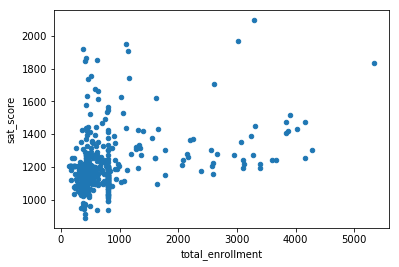

In [37]:
%matplotlib inline

full.plot.scatter(x='total_enrollment', y='sat_score')

In [50]:
full[["DBN","SCHOOL NAME_x","total_enrollment"]]
full[pandas.isnull(full["School Name"])][["SCHOOL NAME_x", "DBN", "School Name"]]

SCHOOL NAME_x     DBN School Name
7                           MANHATTAN BUSINESS ACADEMY  02M392         NaN
8                            BUSINESS OF SPORTS SCHOOL  02M393         NaN
9           THE HIGH SCHOOL FOR LANGUAGE AND DIPLOMACY  02M399         NaN
11               MANHATTAN ACADEMY FOR ARTS & LANGUAGE  02M427         NaN
12         HUDSON HIGH SCHOOL OF LEARNING TECHNOLOGIES  02M437         NaN
13           INTERNATIONAL HIGH SCHOOL AT UNION SQUARE  02M438         NaN
18         THE URBAN ASSEMBLY SCHOOL FOR GREEN CAREERS  03M402         NaN
19                           FRANK MCCOURT HIGH SCHOOL  03M417         NaN
25                    CITY COLLEGE ACADEMY OF THE ARTS  06M293         NaN
26           HIGH SCHOOL FOR EXCELLENCE AND INNOVATION  06M423         NaN
29                 UNIVERSITY HEIGHTS SECONDARY SCHOOL  07X495         NaN
32         BRONX STUDIO SCHOOL FOR WRITERS AND ARTISTS  08X269         NaN
35   ANTONIA PANTOJA PREPARATORY ACADEMY, A COLLEGE...  08X376         NaN
42   BRONX EARLY COLLEGE ACADEMY FOR TEACHING & LEA...  09X324         NaN
54    BRONX CAREER AND COLLEGE PREPARATORY HIGH SCHOOL  12X479         NaN
58   URBAN ASSEMBLY INSTITUTE OF MATH AND SCIENCE F...  13K527         NaN
59   CITY POLYTECHNIC HIGH SCHOOL OF ENGINEERING, A...  13K674         NaN
65                             FRANCES PERKINS ACADEMY  14K632         NaN
69                             SUNSET PARK HIGH SCHOOL  15K667         NaN
72              THE BROOKLYN ACADEMY OF GLOBAL FINANCE  16K688         NaN
82   HIGH SCHOOL FOR INNOVATION IN ADVERTISING AND ...  18K617         NaN
83        ACADEMY FOR CONSERVATION AND THE ENVIRONMENT  18K637         NaN
88      THE URBAN ASSEMBLY SCHOOL FOR CRIMINAL JUSTICE  20K609         NaN
91                   KINGSBOROUGH EARLY COLLEGE SCHOOL  21K468         NaN
105                         YORK EARLY COLLEGE ACADEMY  28Q284         NaN
106                    HILLSIDE ARTS & LETTERS ACADEMY  28Q325         NaN
108                            CAMBRIA HEIGHTS ACADEMY  29Q326         NaN
111           YOUNG WOMEN'S LEADERSHIP SCHOOL, ASTORIA  30Q286         NaN
165                                  THE CINEMA SCHOOL  12X478         NaN
188                                  SCHOLARS' ACADEMY  27Q323         NaN
..                                                 ...     ...         ...
416                                                NaN  09X414         NaN
417                                                NaN  10X397         NaN
418                                                NaN  08X295         NaN
419                                                NaN  12X550         NaN
420                                                NaN  07X655         NaN
421                                                NaN  04M635         NaN
422                                                NaN  29Q496         NaN
423                                                NaN  29Q494         NaN
424                                                NaN  17K625         NaN
425                                                NaN  17K544         NaN
426                                                NaN  02M560         NaN
427                                                NaN  11X541         NaN
428                                                NaN  02M440         NaN
429                                                NaN  05M685         NaN
430                                                NaN  14K404         NaN
431                                                NaN  02M313         NaN
432                                                NaN  10X660         NaN
433                                                NaN  08X650         NaN
434                                                NaN  27Q410         NaN
435                                                NaN  02M394         NaN
436                                                NaN  28Q470         NaN
437                                                NaN  10X475    

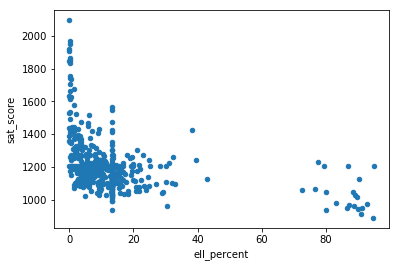

In [51]:
full.plot.scatter(x='ell_percent', y='sat_score')